# _Classifying movie reviews: A binary classification example_


**_Binary classification_** is one of the most common kinds of machine learning problems. In this notebook, you will go through how to classify movie reviews as positive or negative, based on the text content of the review.

Let's start by importing the libraries, we are also using the _IMDB dataset_ comes with the `keras.datasets`.


In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.datasets import imdb
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = (8, 8)

## The IMDB dataset


This dataset consists of 50,000 highly polarized reviews from the Internet Movie Database. They're split into 25,000 reviews for training and 25,000 for testing, each set consists of 50% negative and 50% positive.

Anyway, let's start loading our dataset.


In [2]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000)

The argument `num_words=10000` means you'll only keep the top 10,000 most frequently occuring words in the training data, rare words will be discarded.

Now let's examine our training and testing set.


In [3]:
print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)

(25000,) (25000,)
(25000,) (25000,)


So all of our data and labels are 1D tensors. More specifically, `train_data` and `test_data` are lists of reviews, each review is a list word indices (encoding a sequence of words). `train_labels` and `test_labels` are lists of 0s and 1s, where 0 stands for _negative_ and 1 stands for _positive_.


In [4]:
print(train_data[0])
print(train_labels[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
1


Since we're restricting ourselves to the top 10,000 most frequent words, no word index will exceed 10,000.


In [5]:
max([max(sequence) for sequence in train_data])

9999

## Preparing the data

You might be wondering: "Why the hell is our training data consists of a bunch of numbers that makes no sense?". Well, since we have to do some math while training our model so we must decode words as integers. So of course, you can decode it back into English words.

By using `get_word_index()` provided with the IMDB dataset, we can convert it back to human-readable words.


In [6]:
word_index = imdb.get_word_index()
#Reverse to decode from integer to words
reverse_word_index = dict(
    [(value, key) for key, value in word_index.items()])
decoded_review = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]])
print(decoded_review)

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

So it started to make sense now. That's a great start. But this data cannot be feed into the model yet! Because the model does not accept lists since they all have different lengths, but the neural network expects to process contiguos batches of data. So turning them into tensors is a must. There are 2 ways of doing that:

- Pad your lists so that they all have the same length, turn them into an integer tensor of shape `(samples, max_length)`, and start your model with a layer capable of handling such integer tensors (the `Embedding` layer, which we’ll cover in detail later in the book).
- `Multi-hot encode` your lists to turn them into vectors of 0s and 1s. This would mean, for instance, turning the sequence `[8, 5]` into a 10,000-dimensional vector that would be all 0s except for indices 8 and 5, which would be 1s. Then you could use a `Dense` layer, capable of handling floating-point vector data, as the first layer in your model.

For simplicity, we will go with the latter solution to vectorize the data.

In [7]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1
    return results

In [8]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [9]:
y_train = np.array(train_labels).astype('float32')
y_test = np.array(test_labels).astype('float32')
y_test

array([0., 1., 1., ..., 0., 0., 0.], dtype=float32)

Now we can feed them into a neural network.

## Build your model

The input data is vectors, and the labels are scalars (1s and 0s): this is one of the simplest problem setups you’ll ever encounter. A type of model that performs well on such a problem is a plain stack of densely connected (`Dense`) layers with `relu` activations.

In [10]:
model = keras.Sequential([
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-04-08 00:16:03.038053: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-08 00:16:03.038199: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


The first argument being passed to each `Dense` layer is the number of *units* in the layer: the dimensionality of representation space of the layer. Such `Dense` layer with a `relu` activation implements the following chain of tensor operations:
```
output = relu(dot(input, W) + b)
```

The reason we need to use activation functions like `relu` is that if we don't use it, the `Dense` layer would consist of two linear operations - a dot product and an addition:
```
output = dot(input, W) + b
```

Meaning that the layer can only learn *linear transformations* (affine transformations) of the input data. So instead of having a complex hypothesis space, we have a restricted space and won't benefit from the stacking of layers which originally meant to make the complexity of the hypothesis space.

The last layer is special since it will be our outputs. Here since we have 2 classes (binary), we only need 1 unit to represent that. Instead of `relu`, we are using `sigmoid` function so we can calculate the probability for each classes.

Okay enough with the boring theories, let's get back to building our model by adding our optimizer and loss function.

In [11]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

So here, we are using `rmsprop` as our optimizer, you can choose other optimizers, such as `sgd`, `adam`, etc. But `rmsprop` is a good default choice for virtually any problem. 

For our loss function, we are using `binary_crossentropy`, of course you can use other loss function but considering the fact that we are expecting our output are probabilities, `mean_squared_error` doesn't really fit. And lastly, our `metrics` will be a list of metrics of which we want to keep track. Here, we are only tracking the `accuracy` of our model.

And there you have it, a complete model using **Keras**. From now on, you can explore more types of layers, optimizers and loss functions that comes with **Keras** and **TensorFlow** for many types of deep learning problems without a sweat!

Let's get back on track and start our training session.

## Validating your approach

A deep learning model should never be evaluated on its training data. Imagine a math test where all the problems is just the exercises that you have done in class - it cannot test whether you have actually learned anything, it can only test whether you remembered it or not. Of course, that is not our goal when solving a problem (**_it's Deep Learning, not Deep Remembering!_**).

So what can we do to evaluate our model after training? One general solutions is to reserve a part of the training set and use it to validate our model. Hence, the term 'validation set'.

Here, we are reserving 10,000 samples from the training set as validation set.

In [12]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

Ok now we are prepared to start training our model. In the training process, you can also validate your model at the same time by passing the `validation_data` argument that comes with the `fit` method.

In [13]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20


2022-04-08 00:16:04.198353: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-08 00:16:04.616894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 51ms/step - loss: 0.5373 - accuracy: 0.7782 - val_loss: 0.4188 - val_accuracy: 0.8630
Epoch 2/20


2022-04-08 00:16:06.205499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 16ms/step - loss: 0.3327 - accuracy: 0.9002 - val_loss: 0.3234 - val_accuracy: 0.8805
Epoch 3/20
30/30 [==============================] - 0s 17ms/step - loss: 0.2423 - accuracy: 0.9222 - val_loss: 0.2986 - val_accuracy: 0.8804
Epoch 4/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1893 - accuracy: 0.9406 - val_loss: 0.2730 - val_accuracy: 0.8909
Epoch 5/20
30/30 [==============================] - 1s 17ms/step - loss: 0.1522 - accuracy: 0.9506 - val_loss: 0.2747 - val_accuracy: 0.8890
Epoch 6/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1252 - accuracy: 0.9611 - val_loss: 0.2886 - val_accuracy: 0.8875
Epoch 7/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1043 - accuracy: 0.9688 - val_loss: 0.3086 - val_accuracy: 0.8805
Epoch 8/20
30/30 [==============================] - 0s 16ms/step - loss: 0.0872 - accuracy: 0.9739 - val_loss: 0.3192 - val_accuracy: 0.8835
Epoch 9/20
30/30 [======

`model.fit()` returns a `History` object with a member `history` which is a dictionary that contains data about everything happened during training. This dictionary have one key for each metrics that was monitored during training and validation, which is 4 in this case.

In [14]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Each of these keys corresponds to a list of numbers that is logged during training and validation. For example, we can plot the training, validation loss and accuracy with Matplotlib.

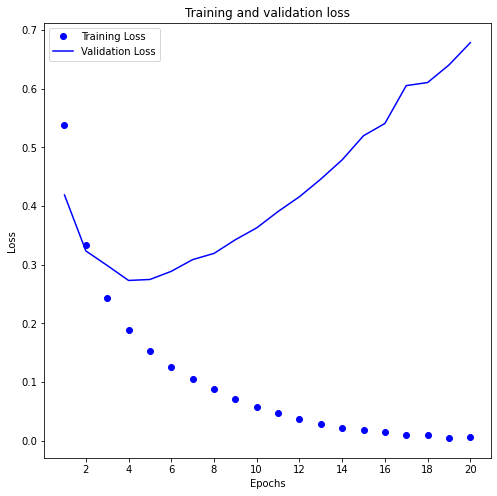

In [15]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks([epoch for epoch in epochs if epoch % 2 == 0])
plt.legend()
plt.show()

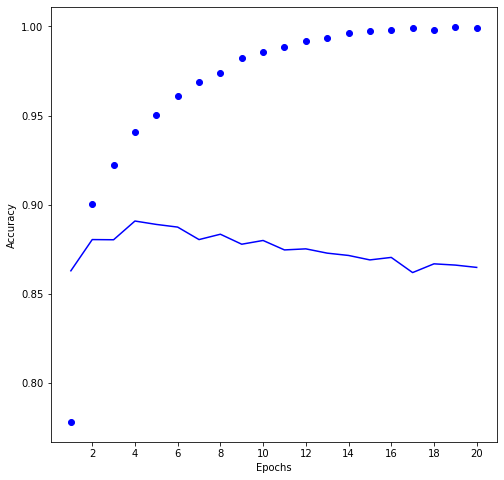

In [16]:
accuracy_values = history_dict['accuracy']
val_accuracy_values = history_dict['val_accuracy']
plt.plot(epochs, accuracy_values, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks([epoch for epoch in epochs if epoch % 2 == 0])
plt.show()

As you can see, training loss decreases with every epoch, and the training accuracy increases with every epoch. That's what you would expect when running Gradient Descent optimization. However, it is not the same case with validation loss and accuracy: they seem to peak at the fourth epoch. 

This is an example of ***overfitting***: after the fourth epoch, we are overoptimizing on the training data, making it learn representations that are specific to the training data but don't generalize well on new data.

Let's train a model from scratch for four epochs and evaluate it on the test data.

In [17]:
model = keras.Sequential([
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train, partial_y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4


2022-04-08 00:16:17.608058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 12ms/step - loss: 0.5209 - accuracy: 0.7868
Epoch 2/4
30/30 [==============================] - 0s 12ms/step - loss: 0.3096 - accuracy: 0.9060
Epoch 3/4
30/30 [==============================] - 0s 16ms/step - loss: 0.2260 - accuracy: 0.9289
Epoch 4/4
 19/782 [..............................] - ETA: 4s - loss: 0.2894 - accuracy: 0.8766

2022-04-08 00:16:21.006974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 5s 7ms/step - loss: 0.2969 - accuracy: 0.8799


This fairly naive approach achieves an accuracy of 88%. With state-of-the-art approaches, we can get close to 95%. But let's leave it simple for now.

## Generate predictions on new data

After training a model, you'll want to use it in a practical setting. You can predict whether the reviews are postive by using the `predict` method.

In [18]:
model.predict(x_test)

2022-04-08 08:54:08.243809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[0.30475459],
       [0.9984408 ],
       [0.70150673],
       ...,
       [0.08458041],
       [0.13204882],
       [0.37424028]], dtype=float32)

You can see that the model is very confident for some samples (0.99 or more, or 0.01 or less) but less confident for others (0.6, 0.4).

## Wrapping up

* You usually need to do quite a bit of preprocessing on your raw data in order to be able to feed it —as tensors— into a neural network. Sequences of words can be encoded as binary vectors, but there are other encoding options too.

* Stacks of `Dense` layers with `relu` activations can solve a wide range of problems (including sentiment classification), and you’ll likely use them frequently.

* In a binary classification problem (two output classes), your model should end with a `Dense` layer with one unit and a `sigmoid` activation: the output of your model should be a scalar between 0 and 1, encoding a probability.

* With such a scalar sigmoid output on a binary classification problem, the loss function you should use is `binary_crossentropy`.

* The `rmsprop` optimizer is generally a good enough choice, whatever your problem. That’s one less thing for you to worry about.

* As they get better on their training data, neural networks eventually start overfitting and end up obtaining increasingly worse results on data they’ve never seen before. Be sure to always monitor performance on data that is outside of the training set.